%matplotlib notebook

In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.control.hybrid_benchmark.utils import big_m, big_m_relaxation
from pympc.dynamics.discrete_time_systems import AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_state_space_trajectory

In [13]:
# physical parameters of the pendulum
l = 1
g = 10
h = .1

# limits for the joint angle
q_min = -.5*np.pi
q_max = 1.5*np.pi
n_lin = 10

In [14]:
def sine_guard(x, y):
    # given x and y in the domain it returs the point where the two linearizations cross
    return (np.sin(y) - np.sin(x) + x*np.cos(x) - y*np.cos(y)) / (np.cos(x) - np.cos(y))

class Interval(object):
    # interval of the real axis
    
    def __init__(self, x, xmin, xmax):
        self.x = x
        self.xmin = xmin
        self.xmax = xmax
        
    def contains(self, x):
        return self.xmin <= x  and x <= self.xmax

class SineLinearization(object):
    # piecewise linearization of the sine function
    
    def __init__(self, x_lin):
        grds = [x_lin[0]]
        grds += [sine_guard(x_lin[i], x_lin[i+1]) for i in range(len(x_lin)-1)]
        grds += [x_lin[-1]]
        self.intervals = [Interval(x_lin[i], grds[i], grds[i+1]) for i in range(len(grds)-1)]
        self.graph = []
        for k, i in enumerate(self.intervals):
            gk = Polyhedron.from_bounds(
                np.array([[i.xmin]]),
                np.array([[i.xmax]]),
                [0],
                2
            )
            gk.add_inequality(
                np.array([[-(h*g/l)*np.cos(i.x), 1.]]),
                np.array([[(h*g/l)*(np.sin(i.x) - i.x*np.cos(i.x))]])
            )
            gk.add_inequality(
                - np.array([[-(h*g/l)*np.cos(i.x), 1.]]),
                - np.array([[(h*g/l)*(np.sin(i.x) - i.x*np.cos(i.x))]])
            )
            self.graph.append(gk)
            
    def evaluate(self, x):
        for i in self.intervals:
            if i.contains(x):
                return (h*g/l) * (np.sin(i.x) + np.cos(i.x)*(x-i.x))

In [15]:
# sample the PWA linearization
n = 1000
q_lin = np.linspace(q_min, q_max, n_lin)
lin = SineLinearization(q_lin)
q_samples = np.linspace(q_min, q_max, n)
vd = (h*g/l)*np.sin(q_samples)
vd_lin = [lin.evaluate(q) for q in q_samples]

In [16]:
# get big M relaxation fo the linearization
R = big_m_relaxation(lin.graph)
R_proj= R.project_to([0,1])

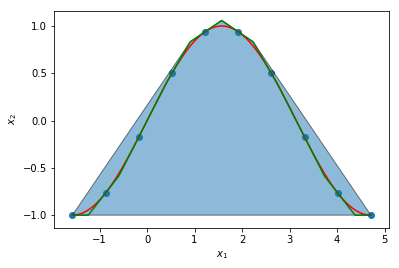

In [17]:
# plot the function vs the relaxation
R_proj.plot(alpha=.5)
plt.plot(q_samples, vd, color='r')
plt.plot(q_samples, vd_lin, color='g')
plt.scatter([q_lin],[(h*g/l)*np.sin(q_lin)])
plt.show()

In [18]:
# discrete time dynamics of the pendulum linearized around a nominal angle
def dt_lin(x):
    A = np.array([[1., h], [(h*g/l)*np.cos(x), 1.]])
    B = np.array([[0.],[h]])
    c = np.array([[0.],[(h*g/l)*(np.sin(x) - x*np.cos(x))]])
    return A, B, c

In [19]:
# polytopic domains
u_min = np.array([[-5.]])
u_max = -u_min
U = Polyhedron.from_bounds(u_min, u_max)
v_min = -5.
v_max = -v_min
x_min = [np.array([[lin.intervals[i].xmin],[v_min]]) for i in range(n_lin)]
x_max = [np.array([[lin.intervals[i].xmax],[v_max]]) for i in range(n_lin)]
X = [Polyhedron.from_bounds(x_min[i], x_max[i]) for i in range(n_lin)]
D = [Xi.cartesian_product(U) for Xi in X]

# affine systems
S = [AffineSystem(*dt_lin(q)) for q in q_lin]

# PWA system
PWA = PieceWiseAffineSystem(S, D)

In [39]:
# controller parameters
N = 30
Q = np.eye(PWA.nx)*h
R = np.eye(PWA.nu)*h

# terminal set and cost
P = Q
X_N = Polyhedron.from_bounds(*[np.zeros((PWA.nx))]*2)

# hybrid controller
controller = HybridModelPredictiveController(PWA, N, Q, R, P, X_N, method='Convex hull, lifted constraints')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


In [40]:
# solve for the given x0
x0 = np.array([[np.pi],[0.]])
u_mip, x_mip, ms_mip, cost_mip, d_mip = controller.feedforward(x0)
print cost_mip
print ms_mip

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Parameter Threads unchanged
   Value: 0  Min: 0  Max: 1024  Default: 0
Optimize a model with 4140 rows, 3112 columns and 12110 nonzeros
Model has 300 quadratic constraints
Variable types: 2812 continuous, 300 integer (300 binary)
Coefficient statistics:
  Matrix range     [2e-03, 5e+00]
  QMatrix range    [5e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [3e+00, 3e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2879 rows and 2109 columns
Presolve time: 0.02s
Presolved: 1261 rows, 1003 columns, 4115 nonzeros
Variable types: 808 continuous, 195 integer (195 binary)

Root relaxation: objective 2.314165e+00, 1066 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.31416    0   34          -    2.31416      -     -    0s
     0     0    2.31416    0   50 

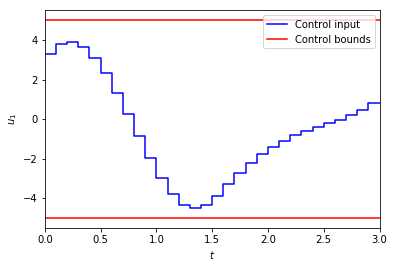

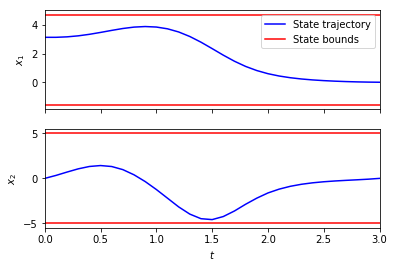

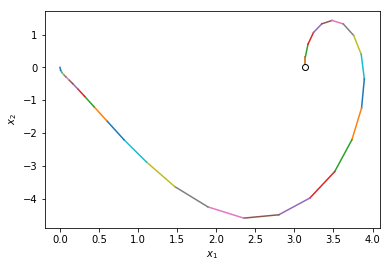

In [24]:
# plots
plot_input_sequence(u_mip, h, (u_min, u_max))
plt.show()
plot_state_trajectory(x_mip, h,(np.array([[q_min],[v_min]]),np.array([[q_max],[v_max]])))
plt.show()
plot_state_space_trajectory(x_mip)
plt.show()